# **Project 3: Hamburger/Hotdog**


## **Import the necessary libraries**

In [1]:
from PIL import Image
import pandas as pd
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# TensorFlow modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# scikit-learn modules
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Library for randomly selecting data points
import random

from Utils import plot_training_history, evaluate_model, plot_confusion_matrix, calculate_additional_metrics, load_and_summarize_model, visualize_feature_maps, plot_cam, plot_precision_recall_curve, plot_roc_curve, plot_conv_filters, plot_misclassified_examples

## **Load and Prepare the Dataset**

- Load and standardize the dataset
- Extract and encode lables.
- Split the data into the train and the test dataset.

In [2]:
# Function to Load Images and Labels
# This function walks through the directory structure, loads the images, converts them into a consistent format,
# resizes them as needed and extracts labels from the directory names:

def load_images_from_folder(folder, count, img_size=(256, 256)):
    images = []
    for idx, filename in enumerate(os.listdir(folder)):
        if idx >= count:  # Only load up to 'count' images
            break
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert to RGB
                img = img.resize(img_size)  # Resize the image
                images.append(np.array(img))
    return np.array(images)

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# Load Images and Create Labels
#hotdog_folder = '/content/hamburger_images'
#hamburger_folder = '/content/hotdog_images'

hotdog_folder = "/content/drive/MyDrive/IMAGES/HOTDOG_SOURCE"
hamburger_folder = "/content/drive/MyDrive/IMAGES/HAMBURGER_SOURCE"

# Load images
hotdog_images = load_images_from_folder(hotdog_folder,1000)
hamburger_images = load_images_from_folder(hamburger_folder,1000)

# Create labels (zeros and ones for the hotdog and notdog images)
hotdog_labels = np.ones(len(hotdog_images))
hamburger_labels = np.zeros(len(hamburger_images))

# Combine images and labels
X = np.concatenate((hotdog_images, hamburger_images), axis=0)
y = np.concatenate((hotdog_labels, hamburger_labels), axis=0)

In [5]:
print(len(hamburger_images))
print(len(hotdog_images))

1000
1000


In [6]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

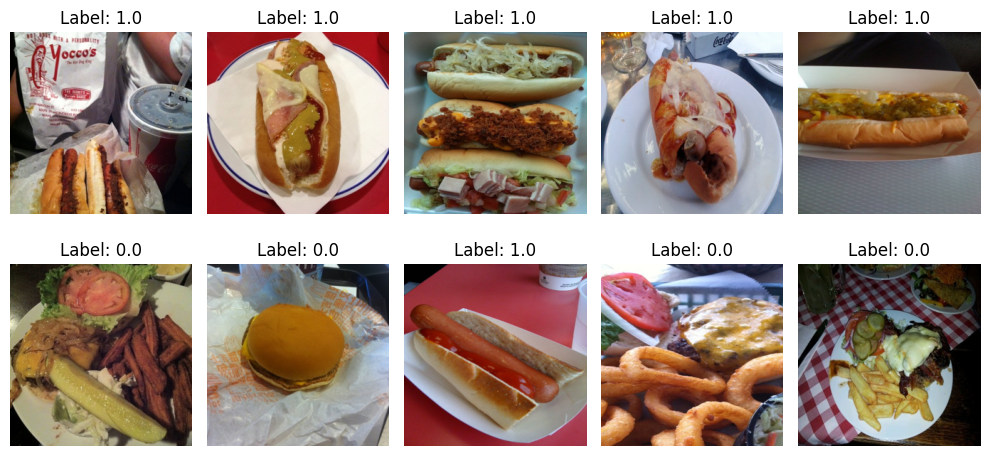

In [7]:
# Visualize the first 10 images in the dataset and printing their classification labels

def plot_images(images, labels, num_images=10):
    # Set up the figure size in inches
    plt.figure(figsize=(10, 5))

    for i in range(num_images):
        # Create a subplot for each image
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')  # Turn off axis numbering

    plt.tight_layout()
    plt.show()

plot_images(X_train, y_train)


## **Data preparation**
- Normalize the train and the test dataset by dividing by 255.

In [8]:
# Normalizing the image pixel inputs
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
# Displaying the first normalized training image
print('Test Dataset:', X_test.shape, y_test.shape)
print('Training Dataset:', X_train.shape, y_train.shape)

Test Dataset: (400, 256, 256, 3) (400,)
Training Dataset: (1600, 256, 256, 3) (1600,)


In [10]:
# Displaying the first normalized testing image and its pixel values
print("Shape of the first normalized testing image:", X_test[0].shape)
print("Pixel values of the first normalized testing image:")
print(X_test[0])

Shape of the first normalized testing image: (256, 256, 3)
Pixel values of the first normalized testing image:
[[[0.6        0.11764706 0.26666667]
  [0.58431373 0.10588235 0.25098039]
  [0.58039216 0.10980392 0.25882353]
  ...
  [0.6        0.81176471 0.98431373]
  [0.6        0.82352941 0.99215686]
  [0.6        0.83137255 0.99607843]]

 [[0.49019608 0.07058824 0.21960784]
  [0.47843137 0.0627451  0.20784314]
  [0.46666667 0.0627451  0.20784314]
  ...
  [0.60392157 0.81568627 0.98823529]
  [0.60392157 0.82745098 0.99607843]
  [0.60392157 0.83137255 1.        ]]

 [[0.35686275 0.04313725 0.19215686]
  [0.35294118 0.04705882 0.19215686]
  [0.34901961 0.05098039 0.19215686]
  ...
  [0.60784314 0.81960784 0.99215686]
  [0.60784314 0.83529412 0.99607843]
  [0.60784314 0.83921569 0.99607843]]

 ...

 [[0.04705882 0.04705882 0.08627451]
  [0.04313725 0.04313725 0.09019608]
  [0.04313725 0.04313725 0.09019608]
  ...
  [0.07843137 0.03921569 0.07058824]
  [0.05882353 0.05490196 0.06666667]
  

## **Analysis**

In [11]:
### Saved Models
model_paths = [
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_1.keras"),
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_2.keras"),
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_3.keras"),
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_4.keras"),
    Path("/content/drive/MyDrive/IMAGES/CNN_Model_5.keras")
]

In [42]:
data = {
    'Model': [],
    'Test Accuracy': [],
    'Test Loss': []
}

for i, model in enumerate(models):
    model_name = f'Model_{i+1}'
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    data['Model'].append(model_name)
    data['Test Accuracy'].append(accuracy)
    data['Test Loss'].append(loss)

# Create DataFrame
df = pd.DataFrame(data)
df

Model  Test Accuracy  Test Loss
0  Model_1         0.6725   1.121722
1  Model_2         0.6600   2.562825
2  Model_3         0.6100   1.512176
3  Model_4         0.6100   0.671048
4  Model_5         0.7025   0.571728

---
### **CNN Model - Iteration #1**

In [12]:
#Load and Summarize Model
model_1 = load_and_summarize_model(model_paths[0])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 64)                33032256  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33033217 (126.01 MB)
Trainable params: 33033217 (126.01 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [ ]:
# Make Predictions
y_pred = model_1.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

12/12 [==============================] - 0s 12ms/step


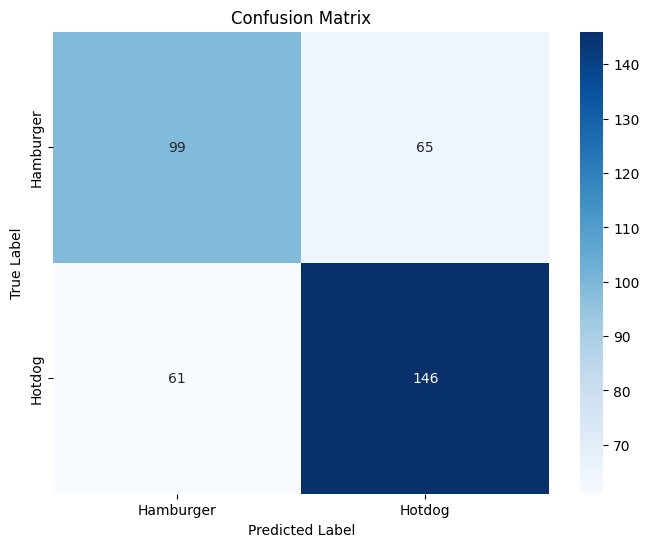

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

1/1 [==============================] - 2s 2s/step
Layer 0 activation shape: (1, 254, 254, 32)
Layer 1 activation shape: (1, 127, 127, 32)
Layer 2 activation shape: (1, 516128)
Layer 3 activation shape: (1, 64)


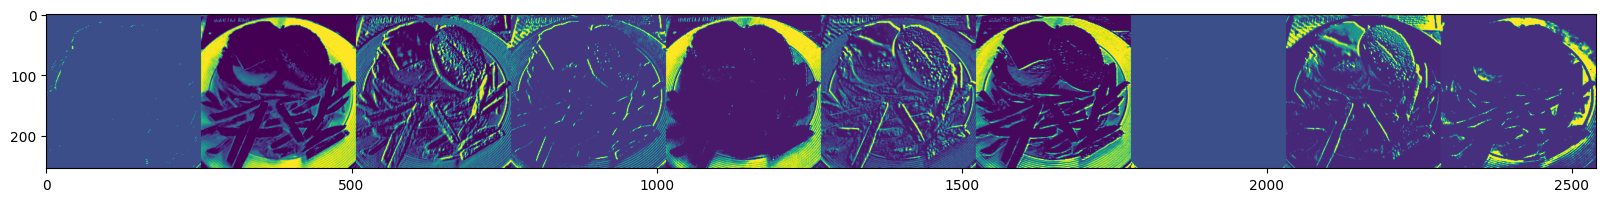

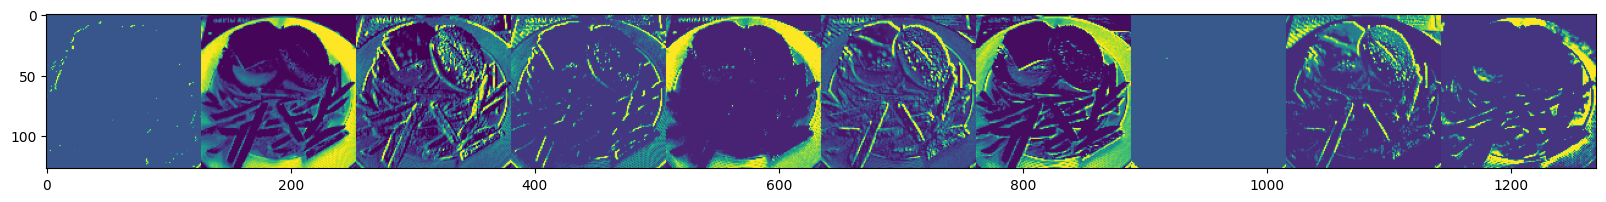

Skipping layer with shape (1, 516128) (not 4D)
Skipping layer with shape (1, 64) (not 4D)


In [13]:
# Evaluating on the Test dataset

from tensorflow.keras import models as keras_models

X_input = X_test[:1]  # Reduce the number of channels to 3

# Visualize feature maps (with reduced number of layers and features to visualize to avoid memory issues)
visualize_feature_maps(model_1, X_input, max_layers=4, max_features=10)

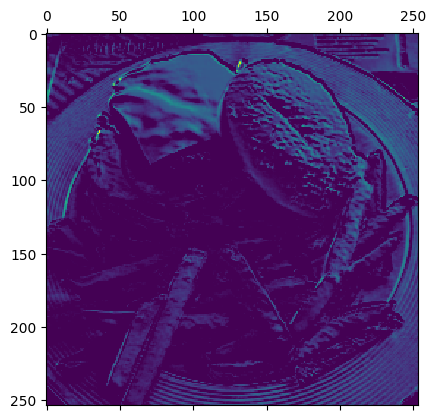

In [16]:
# Class Activation Map
img_array = X_test[:1]
class_idx = np.argmax(y_test[0])
plot_cam(model_1, img_array, class_idx, 'conv2d')  # Specify the convulusional layer name

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_1, X_test, y_test)


13/13 [==============================] - 0s 13ms/step - loss: 1.1217 - accuracy: 0.6725
Test Loss: 1.1217222213745117
Test Accuracy: 0.6725000143051147


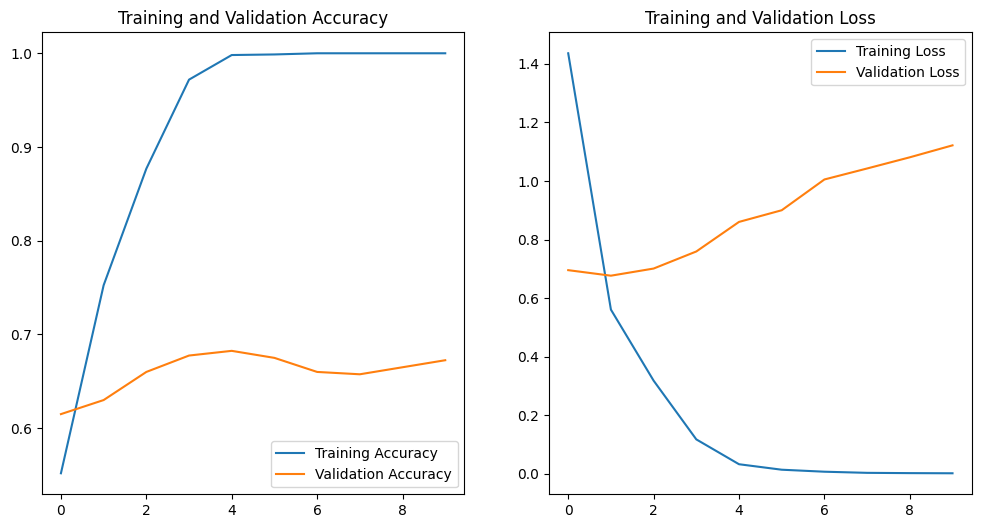

In [ ]:
# Accuracy and Loss Plots
#plot_training_history(history_1) # Copied from Model 1 File: https://github.com/excellentwork/Fantastic_4_Project_3/blob/main/Model_1_Fantastic_4_Project_3.ipynb

13/13 [==============================] - 0s 12ms/step


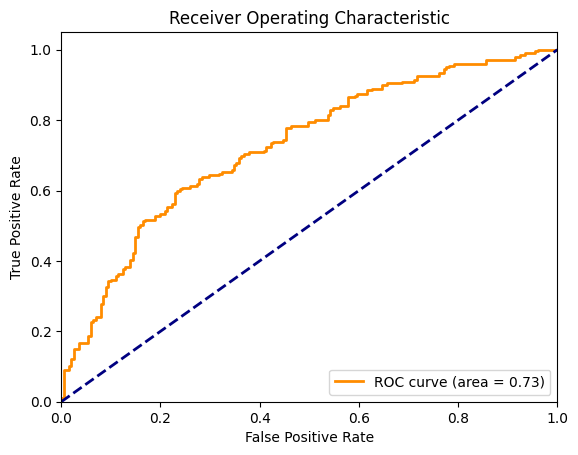

In [16]:
# ROC Curve and AUC
y_pred_probs = model_1.predict(X_test)
plot_roc_curve(y_test, y_pred_probs)

13/13 [==============================] - 0s 12ms/step


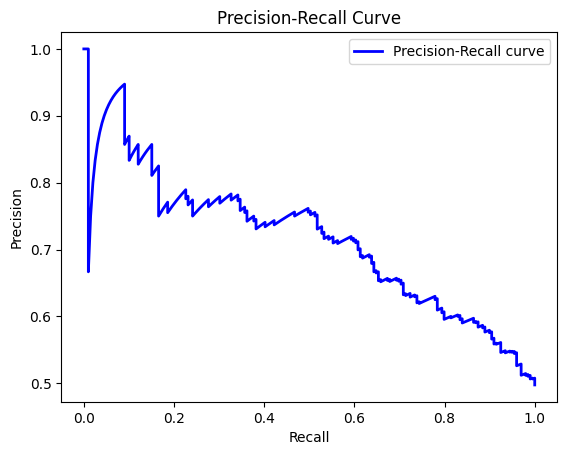

In [14]:
# Precision-Recall Curve
y_pred_probs = model_1.predict(X_test)
plot_precision_recall_curve(y_test, y_pred_probs)

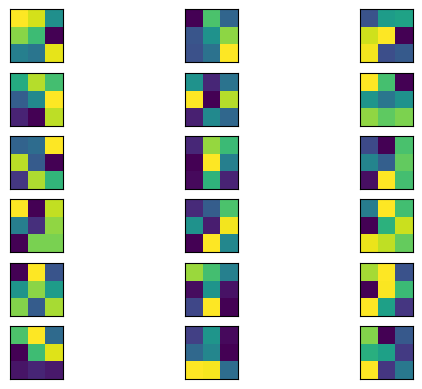

In [15]:
conv_layer = model_1.get_layer('conv2d')
plot_conv_filters(conv_layer, 'conv2d')

### **CNN Model - Iteration #2**

### Augmentation

In [18]:
#Load and Summarize Model
model_2 = load_and_summarize_model(model_paths[1])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 516128)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                33032256  
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33033217 (126.01 MB)
Trainable params: 33033217 (126.01 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
# Make Predictions
y_pred = model_2.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

12/12 [==============================] - 0s 12ms/step


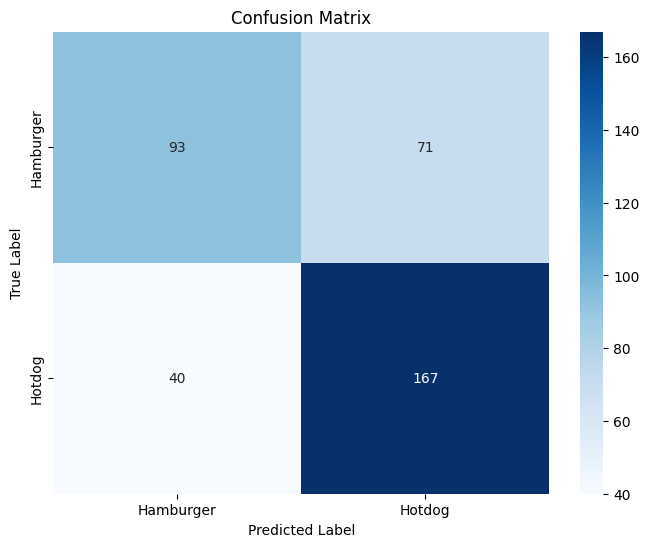

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

1/1 [==============================] - 0s 492ms/step
Layer 0 activation shape: (1, 254, 254, 32)
Layer 1 activation shape: (1, 127, 127, 32)
Layer 2 activation shape: (1, 516128)
Layer 3 activation shape: (1, 64)


/content/Utils.py:144: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/content/Utils.py:147: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


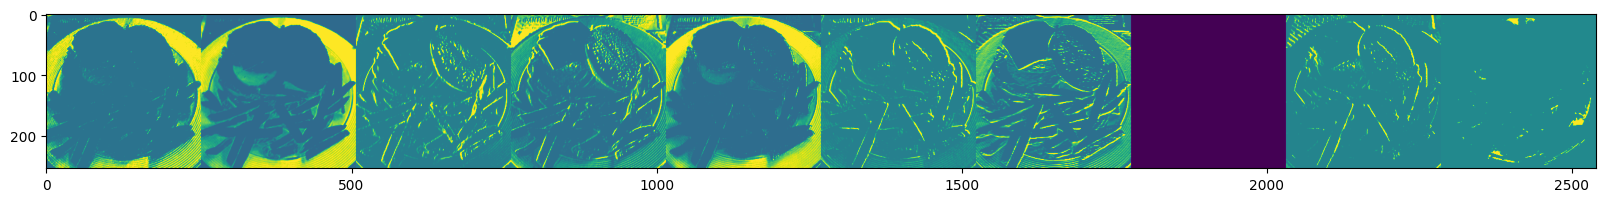

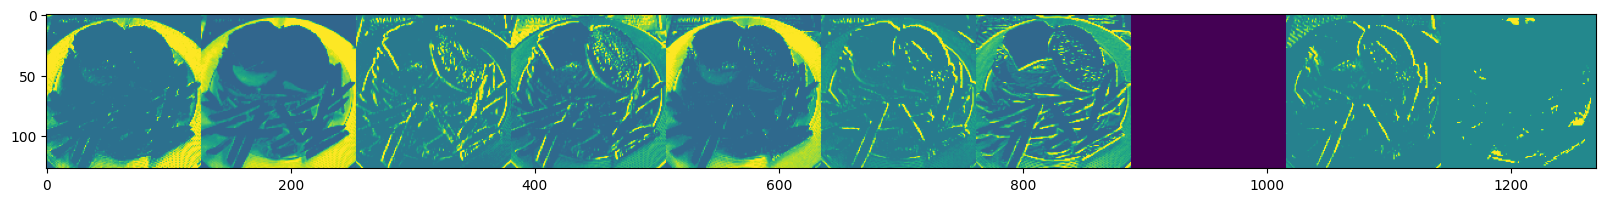

Skipping layer with shape (1, 516128) (not 4D)
Skipping layer with shape (1, 64) (not 4D)


In [19]:
# Evaluating on the Test dataset

from tensorflow.keras import models as keras_models

X_input = X_test[:1]  # Reduce the number of channels to 3

# Visualize feature maps (with reduced number of layers and features to visualize to avoid memory issues)
visualize_feature_maps(model_2, X_input, max_layers=4, max_features=10)

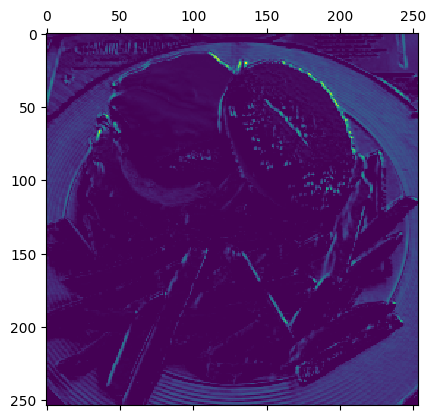

In [21]:
# Class Activation Map
img_array = X_test[:1]
class_idx = np.argmax(y_test[0])
plot_cam(model_2, img_array, class_idx, 'conv2d_1')  # Specify the convulusional layer name

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_2, X_test, y_test)

12/12 [==============================] - 0s 14ms/step - loss: 2.0142 - accuracy: 0.7008
Test Loss: 2.014226198196411
Test Accuracy: 0.7008086442947388


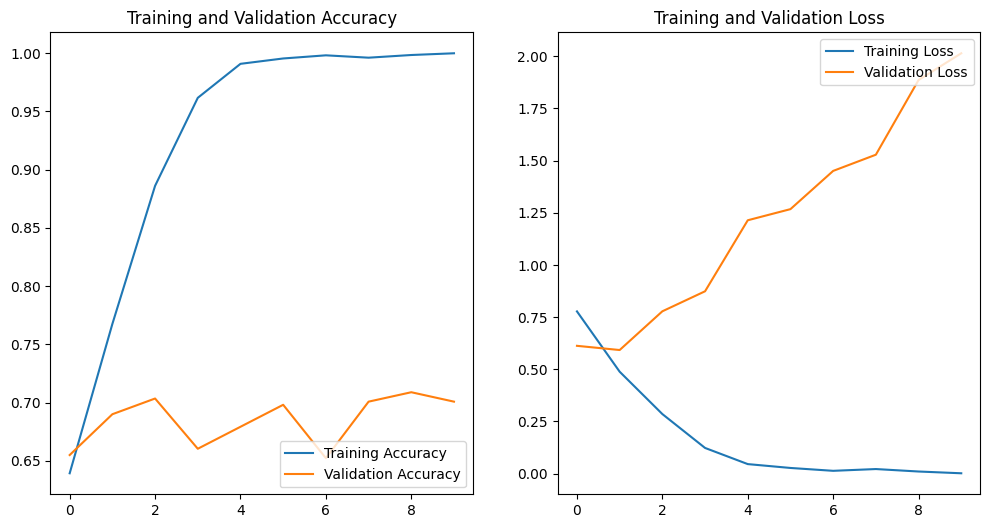

In [ ]:
# Accuracy and Loss Plots
#plot_training_history(history_2) # Copied from Model 2 File: https://github.com/excellentwork/Fantastic_4_Project_3/blob/main/Model_2_Fantastic_4_Project_3.ipynb

13/13 [==============================] - 0s 12ms/step


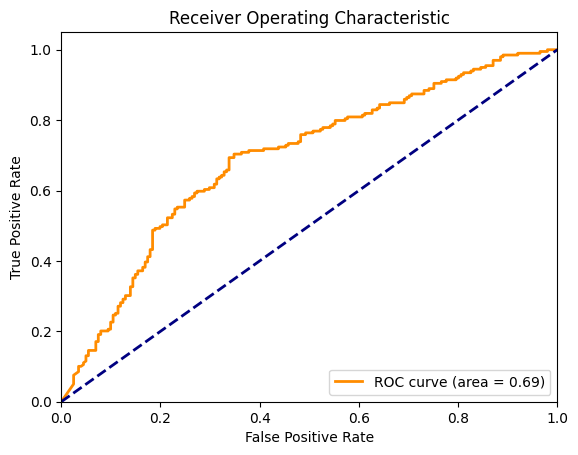

In [22]:
# ROC Curve and AUC
y_pred_probs = model_2.predict(X_test)
plot_roc_curve(y_test, y_pred_probs)

13/13 [==============================] - 0s 12ms/step


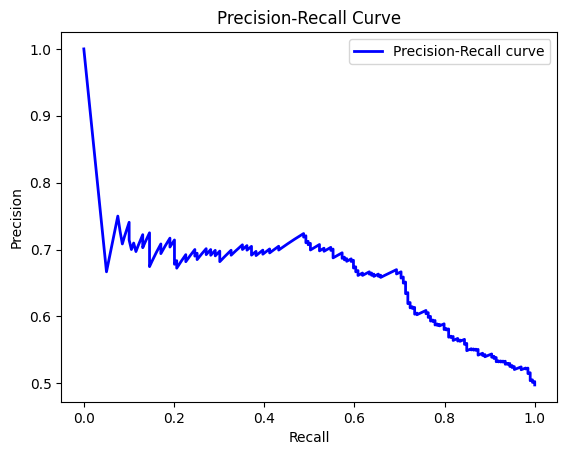

In [23]:
# Precision-Recall Curve
y_pred_probs = model_2.predict(X_test)
plot_precision_recall_curve(y_test, y_pred_probs)

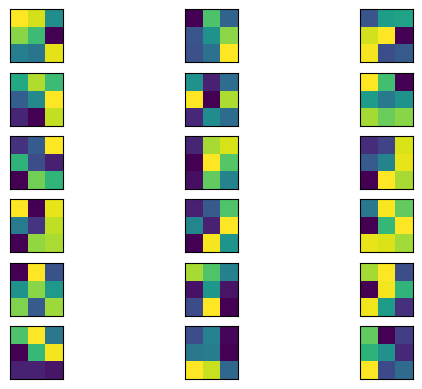

In [25]:
conv_layer = model_2.get_layer('conv2d_1')
plot_conv_filters(conv_layer, 'conv2d_1')

### **CNN Model - Iteration #3**

### Dropout
Dropout is a technique where randomly selected neurons are ignored during training, reducing the chance of overfitting.

In [26]:
#Load and Summarize Model
model_3 = load_and_summarize_model(model_paths[2])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 64)                33032256  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
# Make Predictions
y_pred = model_3.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

12/12 [==============================] - 0s 12ms/step


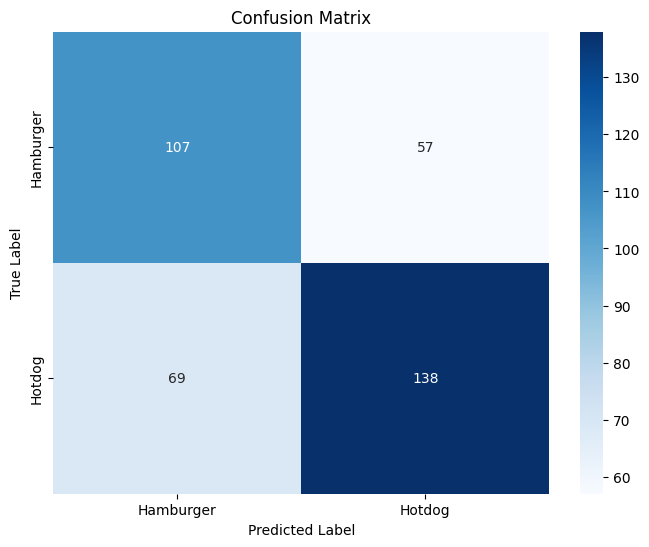

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

1/1 [==============================] - 0s 56ms/step
Layer 0 activation shape: (1, 254, 254, 32)
Layer 1 activation shape: (1, 127, 127, 32)
Layer 2 activation shape: (1, 127, 127, 32)
Layer 3 activation shape: (1, 516128)


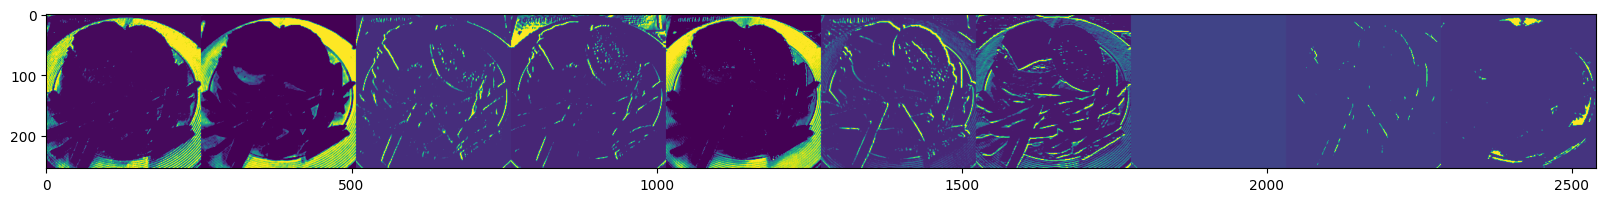

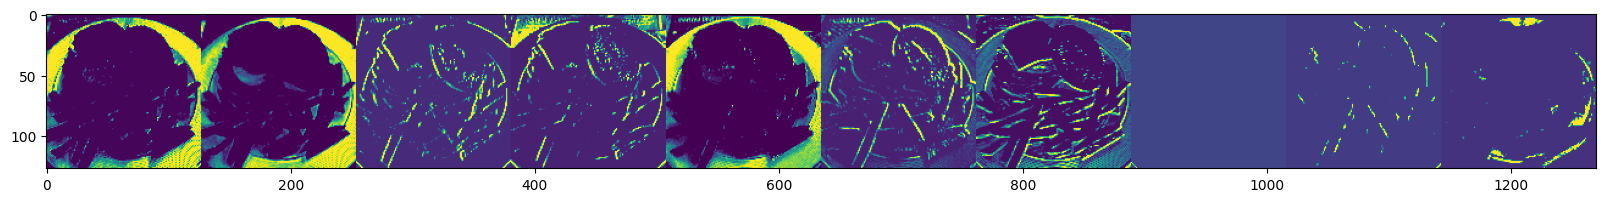

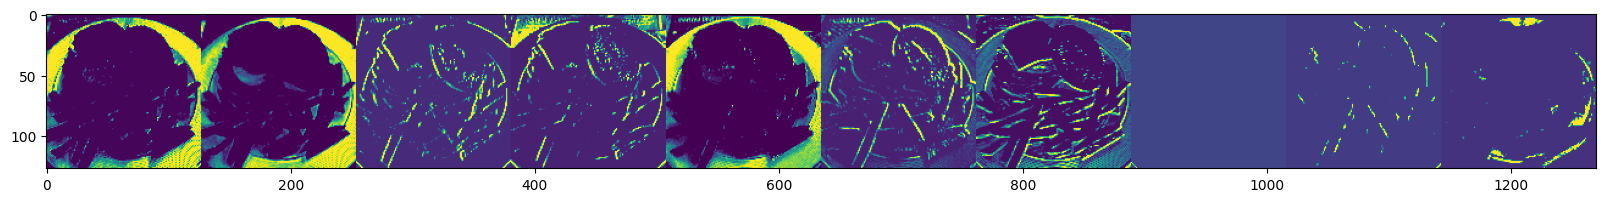

Skipping layer with shape (1, 516128) (not 4D)


In [27]:
# Evaluating on the Test dataset

from tensorflow.keras import models as keras_models

X_input = X_test[:1]  # Reduce the number of channels to 3

# Visualize feature maps (with reduced number of layers and features to visualize to avoid memory issues)
visualize_feature_maps(model_3, X_input, max_layers=4, max_features=10)

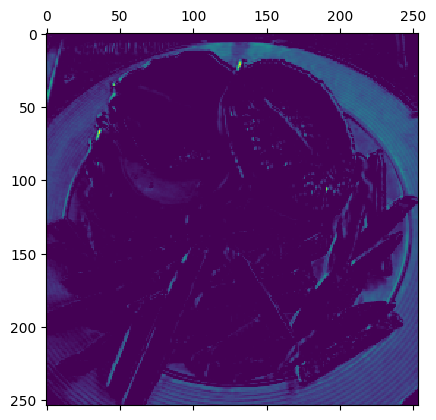

In [29]:
# Class Activation Map
img_array = X_test[:1]
class_idx = np.argmax(y_test[0])
plot_cam(model_3, img_array, class_idx, 'conv2d')  # Specify the convulusional layer name

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_3, X_test, y_test)

12/12 [==============================] - 0s 13ms/step - loss: 1.1747 - accuracy: 0.6604
Test Loss: 1.1747325658798218
Test Accuracy: 0.6603773832321167


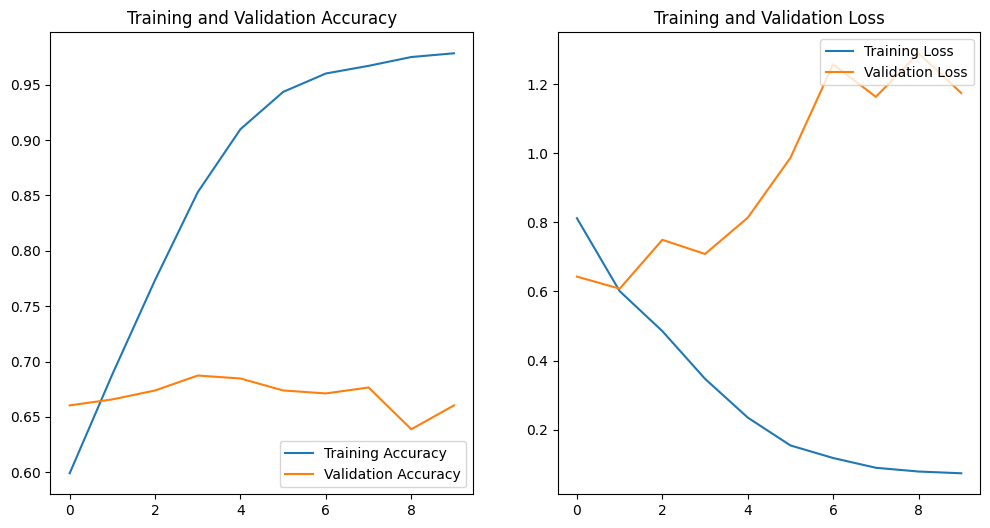

In [ ]:
# Accuracy and Loss Plots
#plot_training_history(history_3) # Copied from Model 3 File: https://github.com/excellentwork/Fantastic_4_Project_3/blob/main/Model_3_Fantastic_4_Project_3.ipynb


13/13 [==============================] - 0s 12ms/step


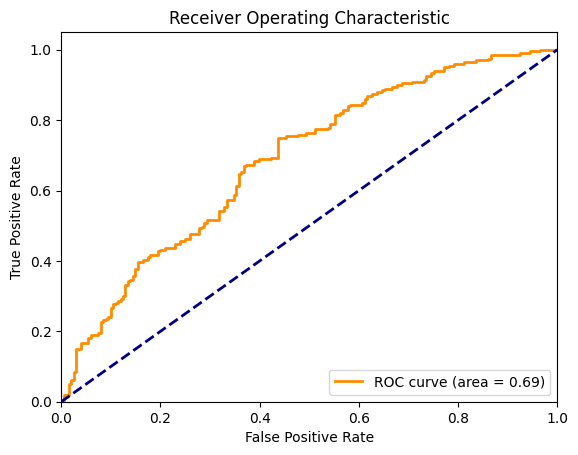

In [30]:
# ROC Curve and AUC
y_pred_probs = model_3.predict(X_test)
plot_roc_curve(y_test, y_pred_probs)

13/13 [==============================] - 0s 12ms/step


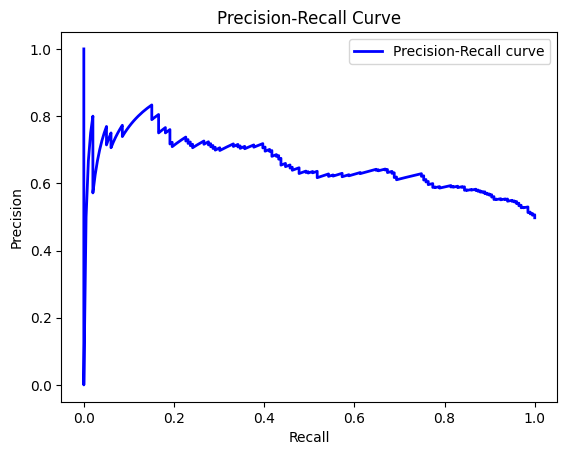

In [31]:
# Precision-Recall Curve
y_pred_probs = model_3.predict(X_test)
plot_precision_recall_curve(y_test, y_pred_probs)

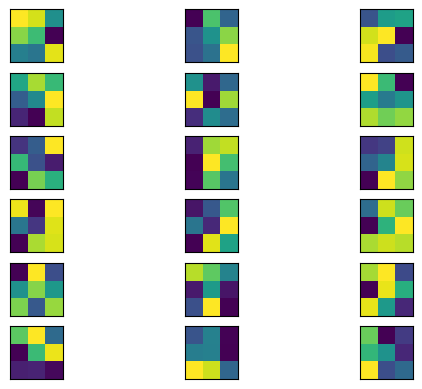

In [33]:
conv_layer = model_3.get_layer('conv2d')
plot_conv_filters(conv_layer, 'conv2d')

### **CNN Model - Iteration #4**

### Early Stopping & Dropout
Early stopping is a method to stop training when the validation metric stops improving, preventing overfitting and saving computational resources.

In [34]:
#Load and Summarize Model
model_4 = load_and_summarize_model(model_paths[3])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 64)                33032256  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
# Make Predictions
y_pred = model_4.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

12/12 [==============================] - 0s 8ms/step


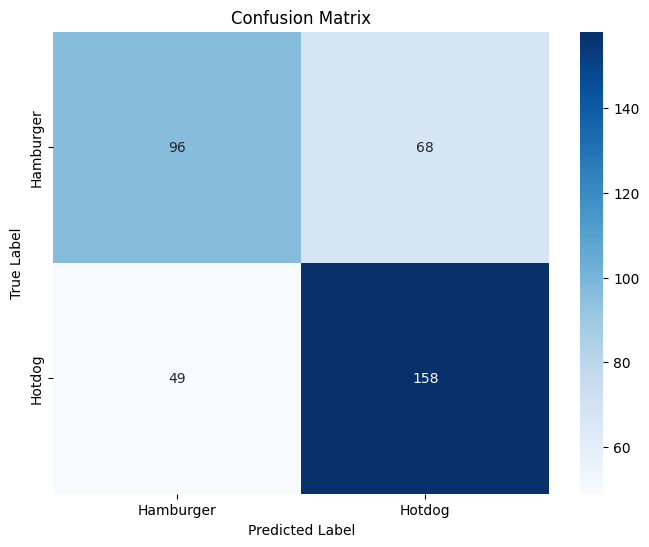

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_4, X_test, y_test)

12/12 [==============================] - 0s 9ms/step - loss: 0.5882 - accuracy: 0.6846
Test Loss: 0.5881525278091431
Test Accuracy: 0.684636116027832


1/1 [==============================] - 0s 52ms/step
Layer 0 activation shape: (1, 254, 254, 32)
Layer 1 activation shape: (1, 127, 127, 32)
Layer 2 activation shape: (1, 127, 127, 32)
Layer 3 activation shape: (1, 516128)


/content/Utils.py:144: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/content/Utils.py:147: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


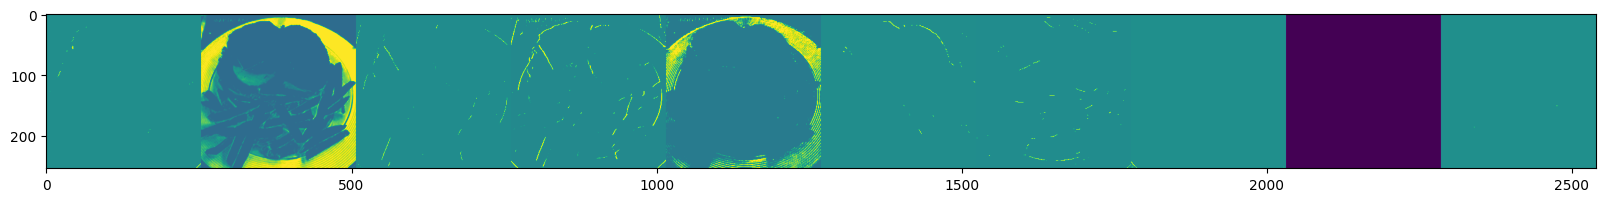

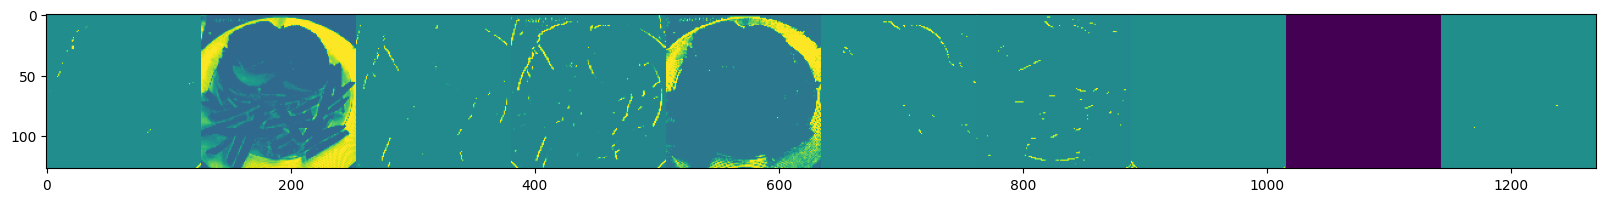

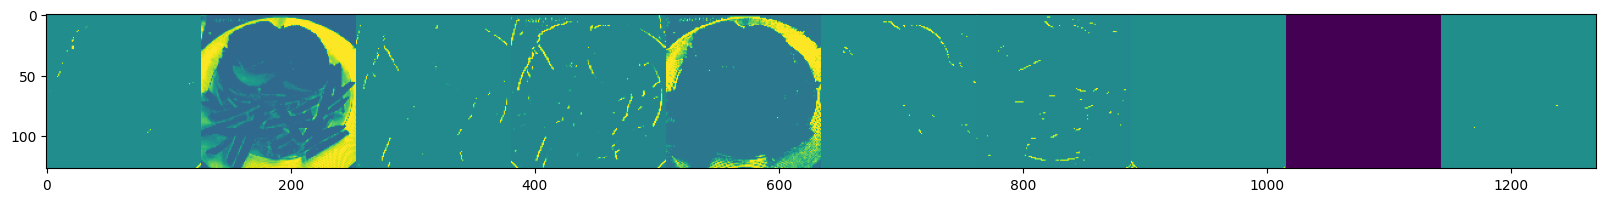

Skipping layer with shape (1, 516128) (not 4D)


In [35]:
# Evaluating on the Test dataset

from tensorflow.keras import models as keras_models

X_input = X_test[:1]  # Reduce the number of channels to 3

# Visualize feature maps (with reduced number of layers and features to visualize to avoid memory issues)
visualize_feature_maps(model_4, X_input, max_layers=4, max_features=10)

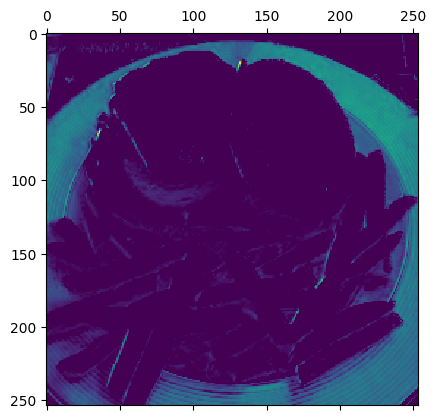

In [36]:
# Class Activation Map
img_array = X_test[:1]
class_idx = np.argmax(y_test[0])
plot_cam(model_4, img_array, class_idx, 'conv2d')  # Specify the convulusional layer name

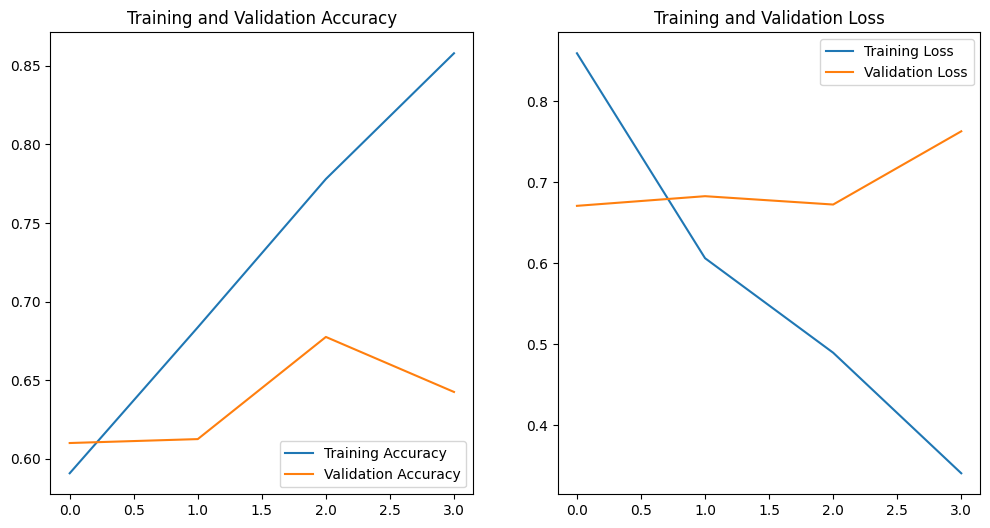

In [ ]:
# Accuracy and Loss Plots
# plot_training_history(history_4) # Copied from Model 4 File: https://github.com/excellentwork/Fantastic_4_Project_3/blob/main/Model_4_Fantastic_4_Project_3.ipynb

13/13 [==============================] - 0s 12ms/step


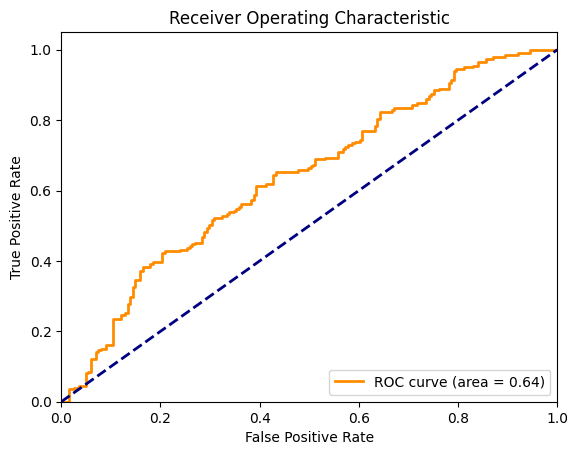

In [37]:
# ROC Curve and AUC
y_pred_probs = model_4.predict(X_test)
plot_roc_curve(y_test, y_pred_probs)

13/13 [==============================] - 0s 13ms/step


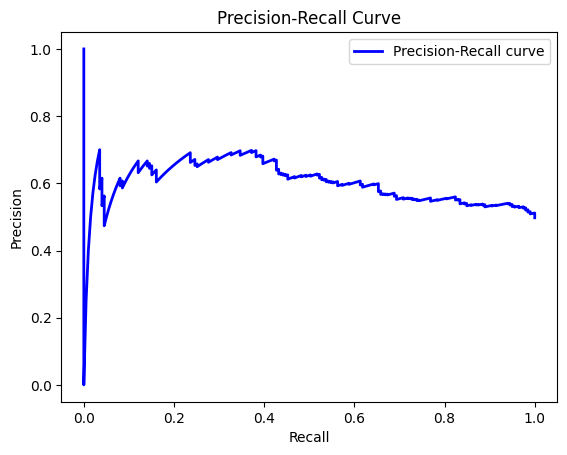

In [38]:
# Precision-Recall Curve
y_pred_probs = model_4.predict(X_test)
plot_precision_recall_curve(y_test, y_pred_probs)

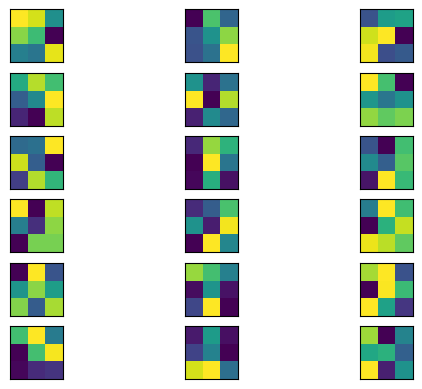

In [39]:
conv_layer = model_4.get_layer('conv2d')
plot_conv_filters(conv_layer, 'conv2d')

### **CNN Model - Iteration #5**

### Additional Layers, Increasing Neurons, Adding Batch Normalization Layers, Early Stopping & Dropout

In [44]:
#Load and Summarize Model
model_5 = load_and_summarize_model(model_paths[4])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_5, X_test, y_test)

In [ ]:
# Accuracy and Loss Plots
plot_training_history(history_5)

In [45]:
# Make Predictions
y_pred = model_5.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

13/13 [==============================] - 0s 19ms/step


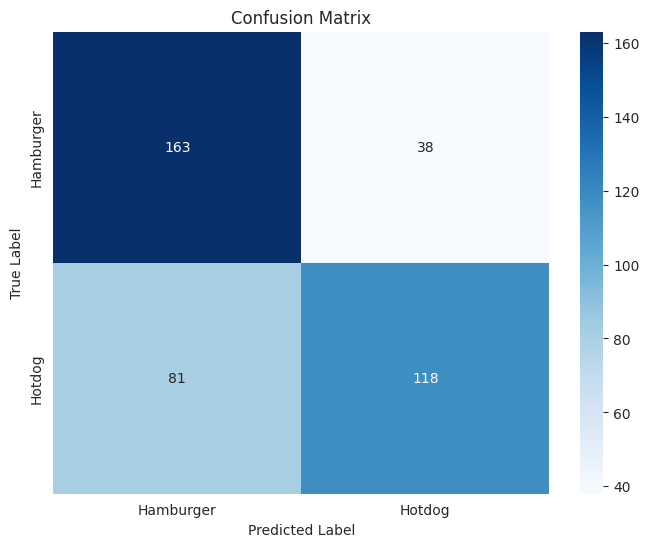

In [46]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

In [47]:
# Evaluating on the Test dataset
evaluate_model(model_5, X_test, y_test)

13/13 [==============================] - 1s 20ms/step - loss: 0.5717 - accuracy: 0.7025
Test Loss: 0.5717282891273499
Test Accuracy: 0.7024999856948853


1/1 [==============================] - 0s 98ms/step
Layer 0 activation shape: (1, 254, 254, 32)
Layer 1 activation shape: (1, 254, 254, 32)
Layer 2 activation shape: (1, 127, 127, 32)
Layer 3 activation shape: (1, 125, 125, 64)


/content/Utils.py:144: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/content/Utils.py:147: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


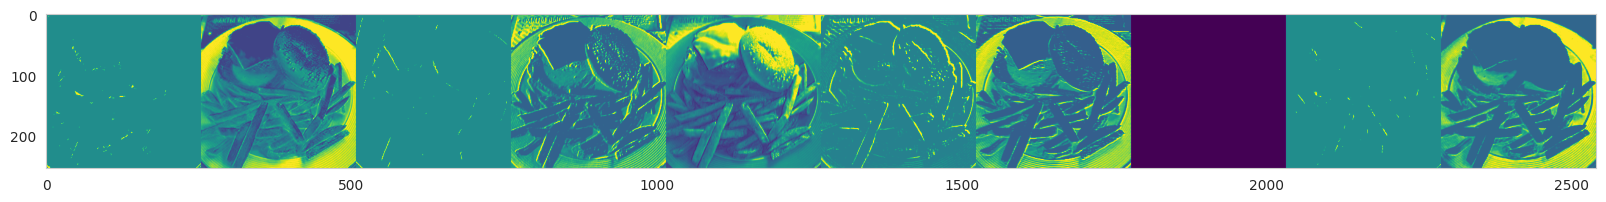

/content/Utils.py:144: RuntimeWarning: divide by zero encountered in divide
  x /= x.std()


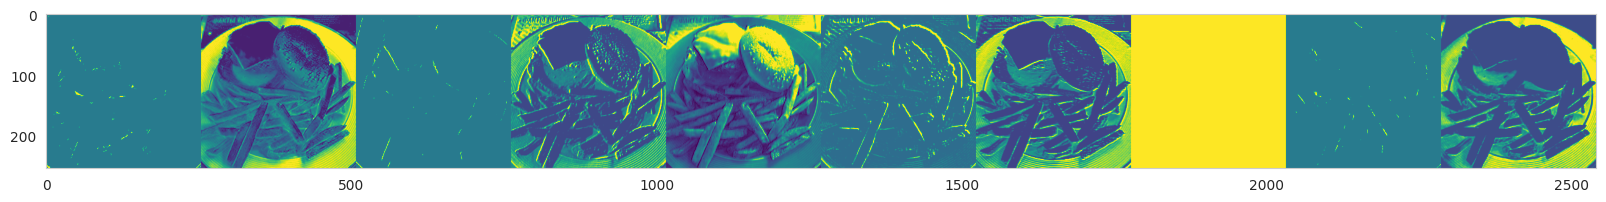

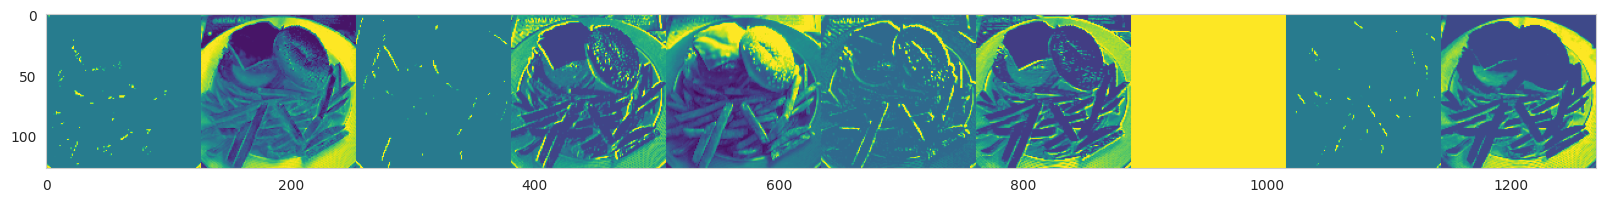

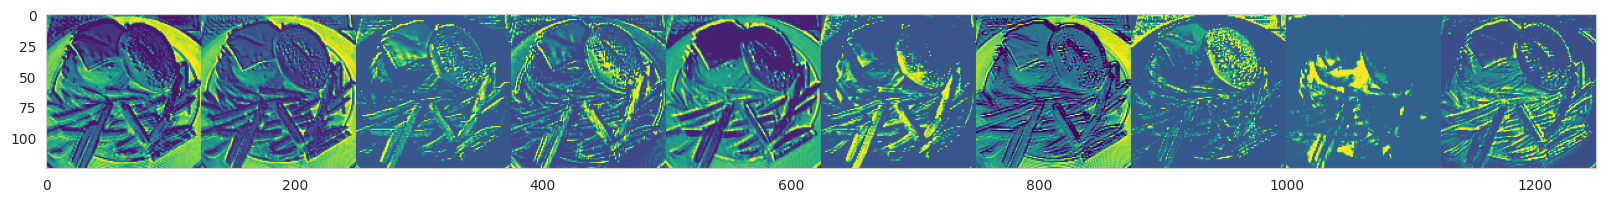

In [48]:
# Evaluating on the Test dataset

from tensorflow.keras import models as keras_models

X_input = X_test[:1]  # Reduce the number of channels to 3

# Visualize feature maps (with reduced number of layers and features to visualize to avoid memory issues)
visualize_feature_maps(model_5, X_input, max_layers=4, max_features=10)

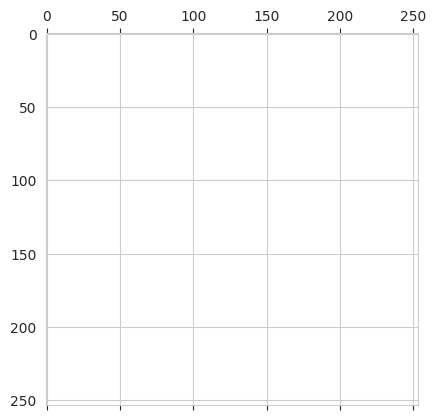

In [50]:
# Class Activation Map
img_array = X_test[:1]
class_idx = np.argmax(y_test[0])
plot_cam(model_5, img_array, class_idx, 'conv2d')  # Specify the convulusional layer name

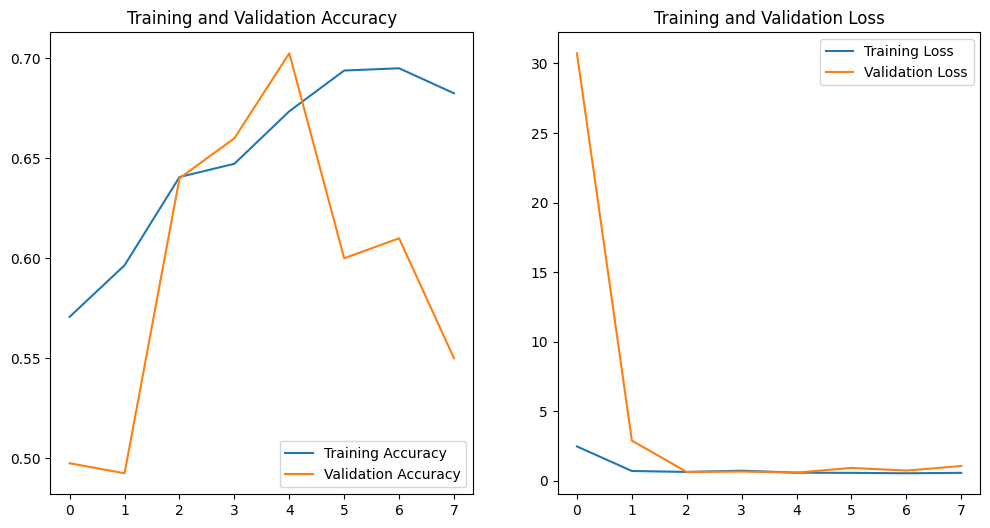

In [ ]:
# Accuracy and Loss Plots
# plot_training_history(history_5) # Copied from Model 5 File: https://github.com/excellentwork/Fantastic_4_Project_3/blob/main/Model_5_Fantastic_4_Project_3.ipynb

13/13 [==============================] - 0s 19ms/step


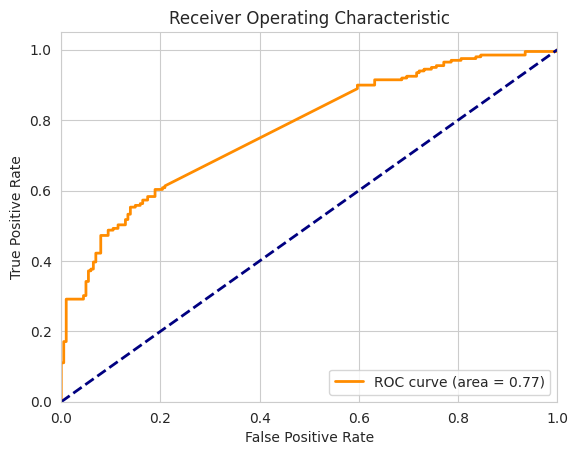

In [51]:
# ROC Curve and AUC
y_pred_probs = model_5.predict(X_test)
plot_roc_curve(y_test, y_pred_probs)

13/13 [==============================] - 0s 19ms/step


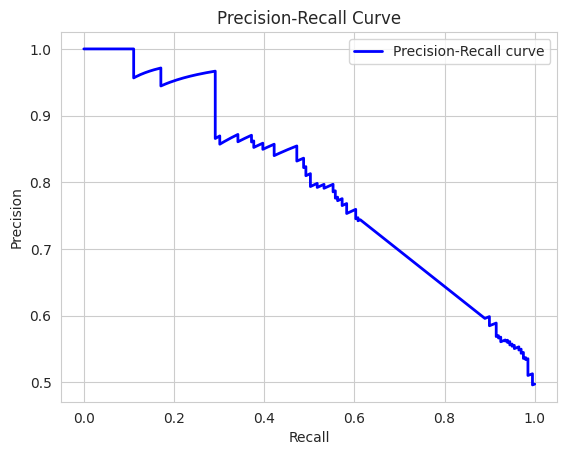

In [52]:
# Precision-Recall Curve
y_pred_probs = model_5.predict(X_test)
plot_precision_recall_curve(y_test, y_pred_probs)

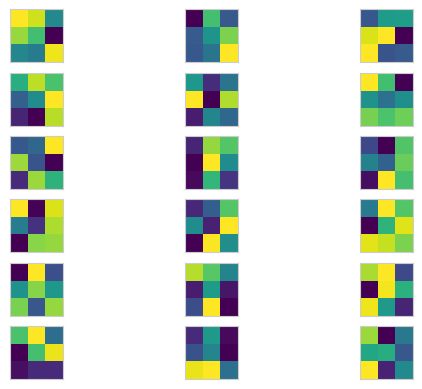

In [53]:
conv_layer = model_5.get_layer('conv2d')
plot_conv_filters(conv_layer, 'conv2d')

### Model Comparison

In [ ]:
from tensorflow.keras.models import load_model

models = [load_model(path) for path in model_paths]
# Dictionary to store performance metrics
performance_metrics = {}

for i, model in enumerate(models):
    model_name = f'model_{i+1}'
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    performance_metrics[model_name] = {'loss': loss, 'accuracy': accuracy}

performance_metrics

{'model_1': {'loss': 1.1217222213745117, 'accuracy': 0.6725000143051147},
 'model_2': {'loss': 2.5628249645233154, 'accuracy': 0.6600000262260437},
 'model_3': {'loss': 1.5121759176254272, 'accuracy': 0.6100000143051147},
 'model_4': {'loss': 0.6710475087165833, 'accuracy': 0.6100000143051147},
 'model_5': {'loss': 0.5717282891273499, 'accuracy': 0.7024999856948853}}

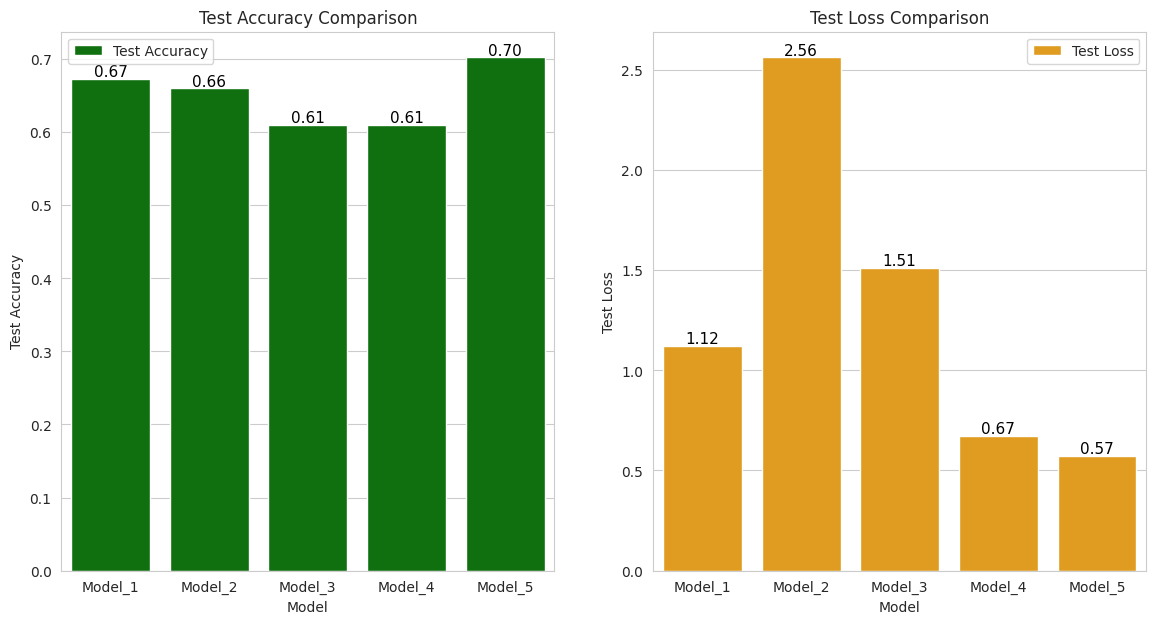

In [43]:
# Set the aesthetic style of the plots
sns.set_style(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(14, 7))

# Plotting Test Accuracy
plt.subplot(121)  # 1 row, 2 cols, subplot 1
ax1 = sns.barplot(x='Model', y='Test Accuracy', data=df, color='green', label='Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()

# Add numerical values on the bars for Accuracy
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Plotting Test Loss
plt.subplot(122)  # 1 row, 2 cols, subplot 2
ax2 = sns.barplot(x='Model', y='Test Loss', data=df, color='orange', label='Test Loss')
plt.title('Test Loss Comparison')
plt.legend()

# Add numerical values on the bars for Loss
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()